In [1]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('../..'))

# ----------- local imports ----------- 
from utils import show_images, build_wandb_run
from sd_utils import get_prompt_embeddings, encode_vae, decode_vae, get_mask
from FashionDataset import FashionDataset, BottomCenterCrop
from constants import TRAIN_PATH, BASE_DIR

2025-03-25 23:51:28.903687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-25 23:51:28.936950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-25 23:51:28.946867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 23:51:29.011398: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-25 23:51:30.839903: W tensorflow/compiler/tf2

In [2]:
import torch
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device).manual_seed(42)
dtype = torch.bfloat16

device

device(type='cuda')

In [18]:
from transformers import CLIPTextModel, CLIPTokenizer


def  get_prompt_embeddings(device, dtype):
    """ get inital prompt embeddings to help model """
    # text encoder components
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)#.to(device)

    prompt = "high-quality face, symmetrical limbs, clear text: 'Standard', An ultra high-resolution, photorealistic image in 8K, A highly detailed photo, showcasing vivid colors and rich contrasts, portrait photo, perfect anatomy, 4k, high quality, full cloth"
    negative_prompt = "nudity (deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
        
    # Tokenize positive and negative prompts
    positive_token_ids = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids']#.to(device)
    negative_token_ids = tokenizer(negative_prompt, padding="max_length", truncation=True, return_tensors="pt")['input_ids']#.to(device)

    # Generate embeddings
    with torch.no_grad():
        positive_embeddings = text_encoder(positive_token_ids).last_hidden_state.type(dtype).to(device)
        negative_embeddings = text_encoder(negative_token_ids).last_hidden_state.type(dtype).to(device)

        combined_embeddings = torch.cat([negative_embeddings, positive_embeddings], dim=0)#.type(dtype)
    
    return positive_embeddings, negative_embeddings, combined_embeddings


positive_embeddings, negative_embeddings, combined_embeddings =  get_prompt_embeddings(device=device, dtype=dtype)

# Load HQ Image

In [4]:
# [corrupted_src + output]
sd_src_output_img = Image.open(BASE_DIR / "output/mo_sala.jpg")
w, h = sd_src_output_img.size
w = w // 2
# open source and resize
src_img = Image.open((BASE_DIR / "mo_salah.jpg")).resize((w, h), Image.BICUBIC)
# get sd output alone
sd_output = np.array(sd_src_output_img)[:,w:,:]

src_sd_output = Image.fromarray(np.concatenate([src_img, sd_output], axis=1) )

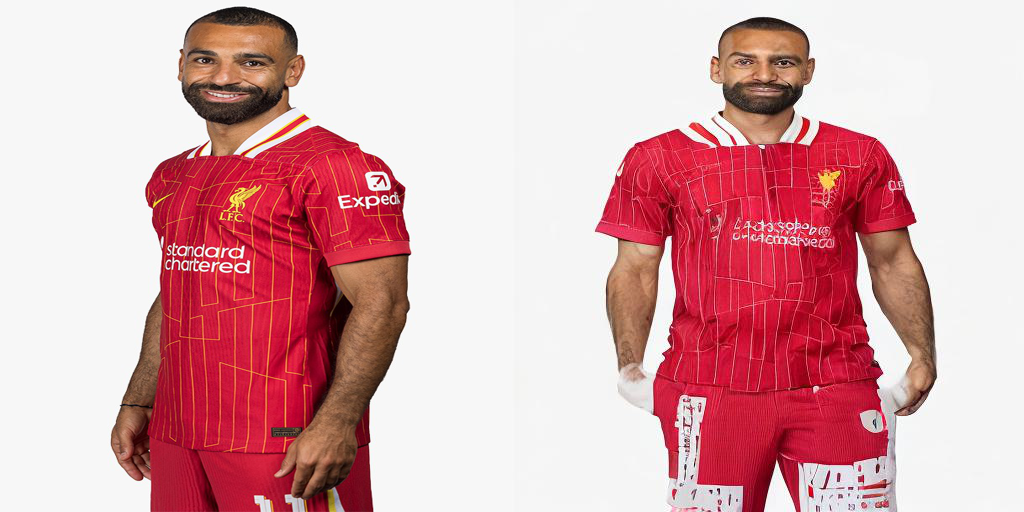

In [5]:
src_sd_output

In [6]:
# =================== Transforms ===================
# original_image = (1101, 750)

# image_resize = (1101, 750) # divided by 3 (H, W)
# image_crop = (1096, 744) # H, W

# img_transform = transforms.Compose([
#     transforms.Resize(image_resize),
#     BottomCenterCrop(image_crop),  # Custom bottom-center crop
# ])

to_tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize([0.5], [0.5])

In [7]:
# # 1. resize + crop images
# src_img = img_transform(src_img_)
# tar_img = img_transform(tar_img_)

# 2. concate src with tar -> convert to tensor -> add batch dimension
init_img = to_tensor_transform( src_sd_output ).unsqueeze(0).type(dtype).to(device)

# 3. generate mask
mask_img = torch.cat([
    torch.zeros((1, 1, h, w)),
    torch.ones((1, 1, h, w)),
], dim=3).type(dtype).to(device)

mask_latents = torch.cat([
    torch.zeros((1, 1, h//8, w//8)),
    torch.ones((1, 1, h//8, w//8)),
], dim=3).type(dtype).to(device)


# # 4. normalize
init_img = normalize_transform(init_img)
masked_img = init_img * (1 - mask_img)

# Load Models

In [8]:
model_id = "SG161222/Realistic_Vision_V6.0_B1_noVAE"    
vae_link = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/vae-ft-mse-840000-ema-pruned.ckpt"
inpainting_link = "https://huggingface.co/SG161222/Realistic_Vision_V6.0_B1_noVAE/blob/main/Realistic_Vision_V6.0_NV_B1_inpainting_fp16.safetensors"


scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
vae = AutoencoderKL.from_single_file(vae_link, torch_dtype=dtype).to(device)

unet = UNet2DConditionModel.from_single_file(inpainting_link, 
                                            subfolder="unet",
                                            torch_dtype=dtype
                                        ).to(device)

# Inference Loop

In [17]:
from diffusers import DPMSolverMultistepScheduler
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

  0%|          | 0/20 [00:00<?, ?it/s]

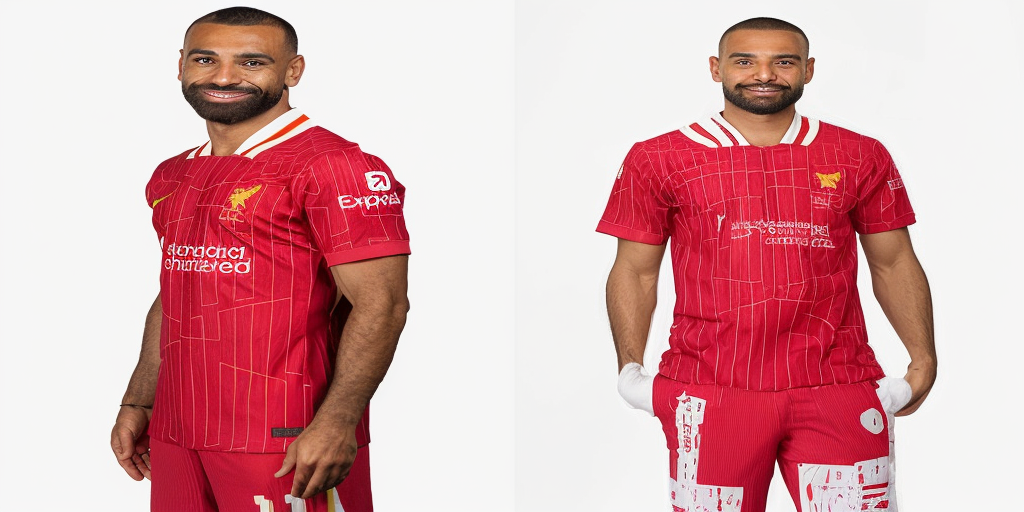

In [38]:
prompt_embeds = torch.cat([positive_embeddings,  negative_embeddings])

strength = 0.2 # @param
num_inference_steps = 100 # @param
guidance_scale = 1.0 # @param

# 1. setup timesteps for scheduler
scheduler.set_timesteps(num_inference_steps)
init_timestep = min(int(num_inference_steps * strength), num_inference_steps) # 42
t_start = max(num_inference_steps - init_timestep, 0) # 8
timesteps = scheduler.timesteps[t_start :]

# 2. generate latents
img_latents = encode_vae(init_img, vae)
noise = torch.randn_like(img_latents, device=device, dtype=dtype)
latents = scheduler.add_noise(img_latents, noise, timesteps[:1]) * scheduler.init_noise_sigma

masked_img_latents = encode_vae(masked_img, vae)


mask_ = torch.cat([mask_latents] * 2)
masked_img_latents_ = torch.cat([masked_img_latents] * 2)

for i, t in tqdm(enumerate(timesteps), total=len(timesteps)):
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    latent_model_input = torch.cat([latent_model_input, mask_, masked_img_latents_], dim=1)
    
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=prompt_embeds).sample
    # perform guidance
    noise_pos, noise_neg = noise_pred.chunk(2)
    noise_pred = noise_neg + guidance_scale * (noise_pos - noise_neg)
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    
out = decode_vae(latents, vae)
show_images(out.type(torch.float32))